# Titanic - Survival Analysis

# Libraries and Utilities

In [1]:
# install required libraries
!pip install fast-ml==3.68
!pip install verstack==3.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 181.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 969.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.2 MB/s eta 0:00:00
  Created wheel for verstack: filename=verstack-3.6.0-py3-none-any.whl siz

In [2]:
!mkdir models

In [3]:
!mkdir output

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import lightgbm as lgb
import optuna
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from fast_ml.feature_selection import get_constant_features
from fast_ml.feature_selection import get_correlated_pairs
from gensim.models import Word2Vec
from random import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,precision_score, confusion_matrix, accuracy_score, roc_curve, f1_score # Several useful metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from tabulate import tabulate
from verstack import NaNImputer

# set the random seed
random_seed = 1234

# target variable name
TARGET = 'Survived'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2022-12-28 13:54:59.848643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 13:55:00.021677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-28 13:55:00.021735: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-28 13:55:01.612901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [5]:
def apply_w2v(sentences, model, num_features):
    """"""
    def _average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        n_words = 0.
        for word in words:
            if word in vocabulary: 
                n_words = n_words + 1.
                feature_vector = np.add(feature_vector, model.wv[word])

        if n_words:
            feature_vector = np.divide(feature_vector, n_words)
        return feature_vector
    
    vocab = set(model.wv.index_to_key)
    feats = [_average_word_vectors(s, model, vocab, num_features) for s in sentences]
    
    return np.array(feats)


def gen_cat2vec_sentences(df):
    """"""
    X_w2v = df.copy(deep=True)
    names = list(X_w2v.columns.values)
    for c in names:
        X_w2v[c] = X_w2v[c].fillna('unknow').astype('category')
        X_w2v[c].cat.categories = ["%s %s" % (c,g) for g in X_w2v[c].cat.categories]
    X_w2v = X_w2v.values.tolist()
    
    return X_w2v


def fit_cat2vec_model(df, n_cat2vec_features, n_cat2vec_window):
    """"""
    X_w2v = gen_cat2vec_sentences(df.sample(frac=0.6))
    for i in X_w2v:
        shuffle(i)    
    model = Word2Vec(X_w2v, vector_size=n_cat2vec_features, window=n_cat2vec_window)
    
    return model


def na_feats_report(df, verbose=True):

    cols = df.columns.tolist()
    nas_list = []
    nas_perc_list = []

    # missing features
    for col in cols:
        nas = df[col].isna().sum()
        nas_list.append(nas)
        nas_perc = nas / df.shape[0]
        nas_perc_list.append(nas_perc)
        if verbose:
            print(col, '-', nas, '/', np.round(nas_perc, 3))

    nas_df = pd.DataFrame([cols, nas_list, nas_perc_list]).T
    nas_df.columns = ['feature', 'nas', 'nas_perc']
    
    return nas_df


def iqr_range_detection(df, col):
    quantiles = df[col].quantile([.25, .75]).values
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    
    lower_limit = Q3 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    
    return lower_limit, upper_limit


def iqr_range_clip(df, cols):
    clipped_cols = []
    
    for col in cols:
        if df[col].nunique() > 10:
            try:
                lower_limit, upper_limit = iqr_range_detection(df, col)
                if (lower_limit != upper_limit
                    and (df.loc[(df[col] > upper_limit) | (df[col] < lower_limit)].shape[0] > 0)):
                    print(f'{col} has {df[col].nunique()} unique values: clipping values outside [{lower_limit}, {upper_limit}]')
                    df[f'{col}'] = df[col].clip(lower=lower_limit, upper=upper_limit)
            except Exception as e:
                print(f'Exception raised by {col}: {e}')

In [6]:
# get the data sources and set the indexes according using the passanger ids
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df.set_index('PassengerId', inplace=True)
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
test_df.set_index('PassengerId', inplace=True)

# split the initial train dataframe into train and evaluation set
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=random_seed)

In [7]:
# check if there are any duplicated passengers
assert len([train_idx
            for train_idx in df.index.tolist() 
            if train_idx in test_df.index.tolist()]) == 0

In [8]:
def preprocess(df, train=True):

    # initial features to drop after being transformed
    to_drop = []

    # Categorical variable treatment
    # decompose the name
    title_pattern = '(Mr\.|Mrs\.|Miss\.|Col\.|Capt\.|Don\.|Master\.|Rev\.|Jonkheer\.|Major\.|Dr\.|Mlle\.|Mme\.|Dona\.|Miss\.)'
    df['Title'] = df['Name'].str.extract(title_pattern)
    # regex to extract the surname from name 
    df['Surname'] = df['Name'].str.extract("(^\w+\s*\'*\-*\w+,|^\w+\s*y\s*\w+,)")
    # regex to extract the spouse name (it's surrounded by parenthesis)
    df['SpouseName'] = df['Name'].str.extract('(\(\"*\w*\s*\"*\w*\.*\"*\s*\w*\s*\w*\s*\w*\s*\"*\))')
    # remove the extracted surname, title and spouse values from the initial name column
    df['NameOnly'] = df.apply(lambda x: (str(x['Name'])
                                         .replace(str(x['Surname']), '')
                                         .replace(str(x['Title']), '')
                                         .replace(str(x['SpouseName']), '')).strip(),
                              axis=1)
    df['Surname'] = df['Surname'].str.replace(',', '', regex=False)
    df['SpouseName'] = df['SpouseName'].str.replace('(', '')
    df['SpouseName'] = df['SpouseName'].str.replace(')', '')
    df['SpouseName'] = df['SpouseName'].str.strip()
    df['SpouseSurname'] = df['SpouseName'].str.extract('(\w+$)')
    df['SpouseName'] = df.apply(lambda x: (str(x['SpouseName'])
                                           .replace(str(x['SpouseSurname']), '')).strip(),
                                axis=1)
    df['SpouseSurname'].fillna('NA', inplace=True)
    df.loc[df['SpouseSurname'] == 'NA', 'SpouseName'] = 'NA'

    # add the initial feature to the TO DROP list
    to_drop.append('Name')

    # ticket and cabin information
    df['Deck'] = df['Cabin'].str.extract('(\w)')
    df['Cabin'] = df['Cabin'].str.replace(r'[A-Z]', '', regex=True)
    df['TicketNumber'] = df['Ticket'].str.extract('([0-9]+$)')
    df['TicketNumber'] = df['TicketNumber'].str.strip()
    # extract the ticket code information
    df['TicketCode'] = df.apply(lambda x: x['Ticket'].replace(str(x['TicketNumber']), '').strip(), axis=1)
    df['TicketCode'] = df['TicketCode'].str.replace('.', '', regex=False)
    df['TicketCode'] = df['TicketCode'].str.upper()
    df['TicketCode'] = df['TicketCode'].str.replace('\s', '', regex=True)
    df['TicketCode'] = df['TicketCode'].str.replace('A/5', 'A5', regex=False)
    df['TicketCode'] = df['TicketCode'].str.replace('A/4', 'A4', regex=False)

    to_drop.append('Ticket')

    # impute missing values 
    # Arbitrary caegory imputation: Let's set the missing values of these features to UNKNOWN
    df['Cabin'].fillna('UNKNOWN', inplace=True)
    df['Deck'].fillna('UNKNOWN', inplace=True)
    df['TicketNumber'].fillna('UNKNOWN', inplace=True)

    imputer = NaNImputer()
    imputed_df = imputer.impute(df)

    na_feats_report(imputed_df)

    # divide features into numerical and categorical
    cat_cols = imputed_df.select_dtypes(include=['O']).columns.tolist()
    num_cols = imputed_df.select_dtypes(exclude=['O']).columns.tolist()

    n_cat2vec_features = len(cat_cols) # define the cat2vecs dimentions
    n_cat2vec_window = len(cat_cols) * 2 # define the w2v window size

    if train:
        c2v_model = fit_cat2vec_model(imputed_df.loc[:, cat_cols], n_cat2vec_features, n_cat2vec_window)
        c2v_model.save('models/c2v_model.w2v')
    else:
        c2v_model = Word2Vec.load('models/c2v_model.w2v')

    # training
    tr_c2v_matrix = apply_w2v(gen_cat2vec_sentences(imputed_df.loc[:, cat_cols]),
                              c2v_model, n_cat2vec_features)

    # add the cat2vec matrix to the corresponding columns 
    imputed_df.loc[:, cat_cols] = tr_c2v_matrix
    
    # remove constant features
    constant_feats = get_constant_features(imputed_df)
    print(tabulate(constant_feats, headers='keys', tablefmt='psql'))

    to_drop += constant_feats['Var'].values.tolist()
    
    # remove correlated pairs     
    temp_to_drop = [1]
    to_drop = []
    i = 1

    while len(temp_to_drop):
        print(f'running round number {i}')
        corr_pairs = get_correlated_pairs(
            imputed_df.drop(columns=to_drop, axis=1)
            .select_dtypes(include=['number'])
        )
        print(tabulate(corr_pairs, headers='keys', tablefmt='psql'))
        temp_to_drop = corr_pairs['feature1'].unique().tolist()

        temp_to_drop = [col for col in temp_to_drop if TARGET not in col]

        print()
        print(f'features to drop: {temp_to_drop}')
        # make sure not to remove the TARGET
        temp_to_drop = list(set(temp_to_drop) - set(TARGET))
        to_drop += temp_to_drop

        i += 1
    
    imputed_df['Age'] = np.round(imputed_df['Age'], 0).astype('int32')
    iqr_range_clip(imputed_df, num_cols)

    if train:
        imputed_df.drop(columns=to_drop, axis=1, inplace=True)
    
    return imputed_df, to_drop
    

In [9]:
train_imputed_df, to_drop_train = preprocess(train_df, train=True)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         623
     .. columns:      19
     .. mb in memory: 0.1
     .. NaN cols num: 2

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 4 to go

   - Imputing single core 2 cols
     . Imputed (regression) - 122      NaN in Age
     . Imputed (multiclass) - 1        NaN in Embarked

   - Missing values after imputation: 0

Time elapsed for impute execution: 0.97447 seconds
Survived - 0 / 0.0
Pclass - 0 / 0.0
Name - 0 / 0.0
Sex - 0 / 0.0
Age - 0 / 0.0
SibSp - 0 / 0.0
Parch - 0 / 0.0
Ticket - 0 / 0.0
Fare - 0 / 0.0
Cabin - 0 / 0.0
Embarked - 0 / 0.0
Title - 0 / 0.0
Surname - 0 / 0.0
SpouseName - 0 / 0.0
NameOnly - 0 / 0.0
SpouseSurname - 0 / 0.0
Deck - 0 / 0.0
TicketNumber - 0 / 0.0
TicketCode - 0 / 0.0
+--------+-------+---------+--------+
| Desc   | Var   | Value   | Perc   |
|--------+-------+---------+--------|
+--------+-------+---------+--------+
running round 

In [10]:
valid_imputed_df, to_drop_valid = preprocess(valid_df, train=False)
valid_imputed_df.drop(columns=to_drop_train, axis=1, inplace=True)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         268
     .. columns:      19
     .. mb in memory: 0.04
     .. NaN cols num: 4

   - Drop hopeless NaN cols
     . Missing values in Surname replaced by "Missing_data" string

   - Processing whole data for imputation
     . Processed 10 cols; 4 to go

   - Imputing single core 3 cols
     . Imputed (regression) - 55       NaN in Age
     . Imputed (multiclass) - 1        NaN in Embarked
     . Imputed (multiclass) - 4        NaN in Title

   - Missing values after imputation: 0

Time elapsed for impute execution: 1.23694 seconds
Survived - 0 / 0.0
Pclass - 0 / 0.0
Name - 0 / 0.0
Sex - 0 / 0.0
Age - 0 / 0.0
SibSp - 0 / 0.0
Parch - 0 / 0.0
Ticket - 0 / 0.0
Fare - 0 / 0.0
Cabin - 0 / 0.0
Embarked - 0 / 0.0
Title - 0 / 0.0
Surname - 0 / 0.0
SpouseName - 0 / 0.0
NameOnly - 0 / 0.0
SpouseSurname - 0 / 0.0
Deck - 0 / 0.0
TicketNumber - 0 / 0.0
TicketCode - 0 / 0.0
+--------+-------+---------+--------+
| Desc  

In [11]:
test_imputed_df, to_drop_test = preprocess(test_df, train=False)
test_imputed_df.drop(columns=to_drop_train, axis=1, inplace=True)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         418
     .. columns:      18
     .. mb in memory: 0.06
     .. NaN cols num: 3

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 5 to go

   - Imputing single core 3 cols
     . Imputed (regression) - 86       NaN in Age
     . Imputed (regression) - 1        NaN in Fare
     . Imputed (multiclass) - 1        NaN in Title

   - Missing values after imputation: 0

Time elapsed for impute execution: 1.30048 seconds
Pclass - 0 / 0.0
Name - 0 / 0.0
Sex - 0 / 0.0
Age - 0 / 0.0
SibSp - 0 / 0.0
Parch - 0 / 0.0
Ticket - 0 / 0.0
Fare - 0 / 0.0
Cabin - 0 / 0.0
Embarked - 0 / 0.0
Title - 0 / 0.0
Surname - 0 / 0.0
SpouseName - 0 / 0.0
NameOnly - 0 / 0.0
SpouseSurname - 0 / 0.0
Deck - 0 / 0.0
TicketNumber - 0 / 0.0
TicketCode - 0 / 0.0
+--------+-------+---------+--------+
| Desc   | Var   | Value   | Perc   |
|--------+-------+---------+--------|
+--------+-------+----

In [12]:
X_train = train_imputed_df.drop(columns=[TARGET], axis=1)
y_train = train_imputed_df[[TARGET]]

X_valid = valid_imputed_df.drop(columns=[TARGET], axis=1)
y_valid = valid_imputed_df[[TARGET]]

X_test = test_imputed_df.copy(deep=True)

In [13]:
# create dataset for lightgbm
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# specify your configurations as a dict

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'feature_pre_filter': False,
    
    
    'lambda_l1': 2.0613308284770256e-08, 
    'lambda_l2': 1.2501186755034501e-06,
    'num_leaves': 124,
    'feature_fraction': 0.8671073372934706,
    'bagging_fraction': 0.9418378329425231,
    'bagging_freq': 6,
    'min_child_samples': 17
    
}

print('Starting training...')
# train
clf = lgb.train(params,
                dtrain,
                num_boost_round=20,
                valid_sets=dvalid,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

print('Saving model...')
# save model to file
clf.save_model('model.txt')

print('Starting predicting...')
# predict
y_train_pred = clf.predict(X_train, num_iteration=clf.best_iteration)
y_valid_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
y_test_pred = clf.predict(X_test, num_iteration=clf.best_iteration)

# compute the predicted labels
# train set
y_train_pred_class = y_train_pred > 0.5
y_train_pred_class = y_train_pred_class.astype(int)
# validation set
y_valid_pred_class = y_valid_pred > 0.5
y_valid_pred_class = y_valid_pred_class.astype(int)
# test set
y_test_pred_class = y_test_pred > 0.5
y_test_pred_class = y_test_pred_class.astype(int)

Starting training...
[LightGBM] [Info] Number of positive: 240, number of negative: 383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385233 -> initscore=-0.467396
[LightGBM] [Info] Start training from score -0.467396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [14]:
scoring_df = X_test.copy(deep=True)
scoring_df['Survived'] = y_test_pred_class
scoring_df.reset_index(inplace=True)
scoring_df = scoring_df[['PassengerId', 'Survived']]

scoring_df.to_csv('output/scoring.csv', index=False)

In [15]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_seed)
tmp_best_params = {
    "objective": "binary",
    "metric": "binary_error",
    "verbosity": -1,
    "boosting_type": "gbdt",                
    "seed": random_seed,
    'feature_pre_filter': False,
    
    
    'lambda_l1': 0.012277548072934017,
    'lambda_l2': 0.12761375962313365,
    'num_leaves': 191,
    'feature_fraction': 0.612083319277447,
    'bagging_fraction': 0.6956054006849886,
    'bagging_freq': 0,
    'min_child_samples': 19
}

best_score = 0.0

In [16]:
# Declare how we evaluate how good a set of hyperparameters are, i.e.
# declare an objective function.
def objective(trial):
    # Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": random_seed,
        'feature_pre_filter': False,
        
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    
    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   dtrain,
#                    categorical_feature=ids_of_categorical,
                   folds=rkf,
                   verbose_eval=False,                   
                   early_stopping_rounds=250,                   
                   num_boost_round=10000,                    
                   callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ]
                  )
    
    cv_score = lgbcv['binary_error-mean'][-1] + lgbcv['binary_error-stdv'][-1]
    if cv_score < best_score:
        training_rounds = len( list(lgbcv.values())[0] )
    
    # Return metric of interest
    return cv_score

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# We search for another 4 hours (3600 s are an hours, so timeout=14400).
# We could instead do e.g. n_trials=1000, to try 1000 hyperparameters chosen 
# by optuna or set neither timeout or n_trials so that we keep going until 
# the user interrupts ("Cancel run").
study = optuna.create_study(direction='minimize')  
study.enqueue_trial(tmp_best_params)
study.optimize(objective, n_trials=10, timeout=14400) 

In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
optuna.visualization.plot_param_importances(study)

In [19]:
print(study.best_params)

{'lambda_l1': 0.012277548072934017, 'lambda_l2': 0.12761375962313365, 'num_leaves': 191, 'feature_fraction': 0.612083319277447, 'bagging_fraction': 0.6956054006849886, 'bagging_freq': 0, 'min_child_samples': 19}


In [20]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

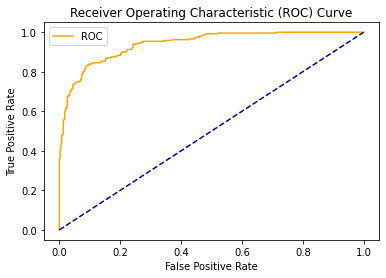

0.94


In [21]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr, tpr)

print(np.round(roc_auc_score(y_train, y_train_pred, average=None), 2))

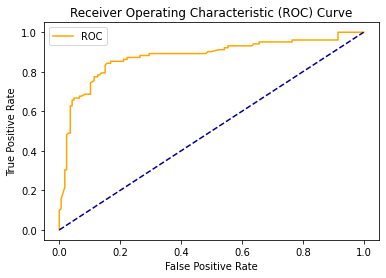

0.88


In [22]:
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred)
plot_roc_curve(fpr, tpr)

print(np.round(roc_auc_score(y_valid, y_valid_pred, average=None), 2))

In [23]:
# Create Confusion Matrix
pred_class = y_valid_pred > 0.5
pred_class = pred_class.astype(int)
cm = confusion_matrix(y_valid, pred_class)
print(cm)

# Get accuracy
accuracy = round(accuracy_score(y_valid,pred_class),4)
print("Accuracy: {}".format(np.round(accuracy, 2)),"\n")

# Get f1 score (it is required on the Task 1 of this dataset)
f1 = f1_score(y_valid,pred_class)
print("F1: {}".format(f1),"\n")


[[155  11]
 [ 34  68]]
Accuracy: 0.83 

F1: 0.7513812154696132 



In [24]:
# Create Confusion Matrix
pred_class = y_valid_pred > 0.5
pred_class = pred_class.astype(int)
cm = confusion_matrix(y_valid, pred_class)
print(cm)

# Get accuracy
accuracy = round(accuracy_score(y_valid,pred_class),4)
print("Accuracy: {}".format(np.round(accuracy, 2)),"\n")

# Get f1 score (it is required on the Task 1 of this dataset)
f1 = f1_score(y_valid,pred_class)
print("F1: {}".format(f1),"\n")


[[155  11]
 [ 34  68]]
Accuracy: 0.83 

F1: 0.7513812154696132 



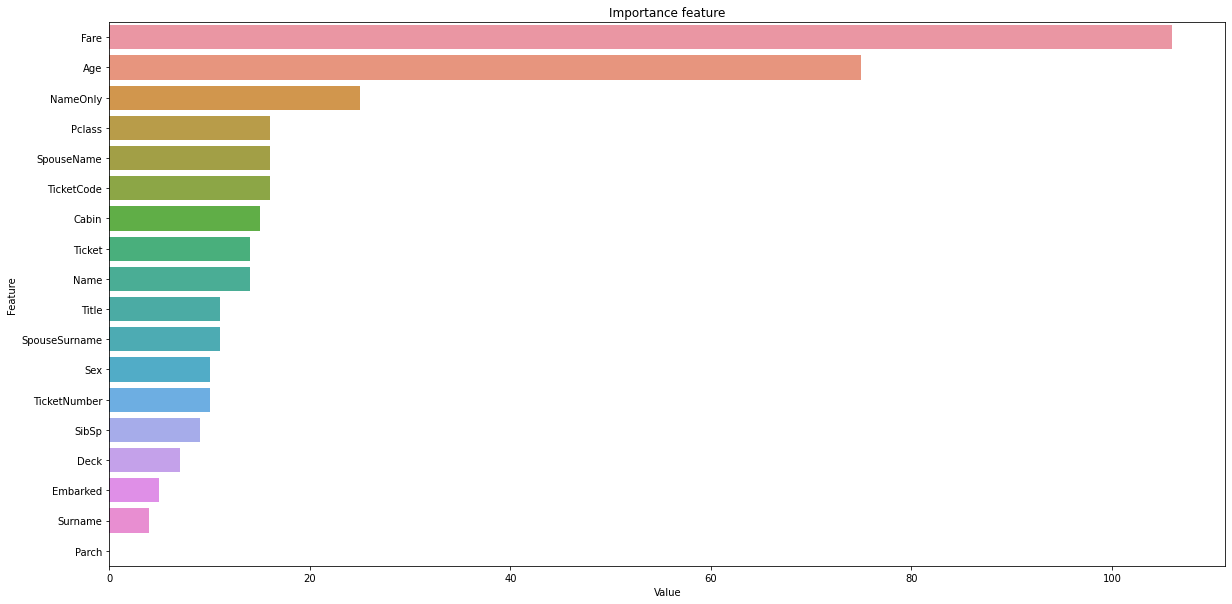

In [25]:
# See the feature importance
importance_feature = pd.DataFrame({
    'Value': clf.feature_importance(),
    'Feature':clf.feature_name()
}).sort_values(by="Value", ascending=False)

# Create a plot
plt.figure(figsize=(20, 10))
sns.barplot(x='Value', y='Feature', data=importance_feature);
plt.title("Importance feature");


In [26]:
# # transform categorical features into categories and add their appropiate category label
# df['Survived'] = df['Survived'].astype('category')
# df['Survived'] = df['Survived'].map({0: 'No', 1: 'Yes'})
# df['Pclass'] = df['Pclass'].astype('category')
# df['Pclass'] = df['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})
# df['Embarked'] = df['Embarked'].astype('category')
# df['Embarked'] = df['Embarked'].map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})
# df['SexCat'] = 1
# df.loc[df['Sex'] == 'female', 'SexCat'] = 0
# df['SexCat'] = df['SexCat'].map({0: 'Female', 1: 'Male'})
# df['SexCat'] = df['SexCat'].astype('category')
# df['CabinLetter'] = df['CabinLetter'].astype('category')

In [27]:
# feat_des = {
#     "Survived": "Survival",
#     "pclass": "Ticket class",
#     "sex": "Sex",
#     "Age": "Age in years",
#     "sibsp": "# of siblings / spouses aboard the Titanic",
#     "parch": "# of parents / children aboard the Titanic",
#     "ticket": "Ticket number",
#     "fare": "Passenger fare",
#     "cabin": "Cabin number",
#     "embarked": "Port of Embarkation",
# }